# Práctica 3 - Ruido y Filtros

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from PIL import Image, ImageChops
from math import pi, exp, sqrt, log
from scipy.signal import convolve2d

plt.rcParams['figure.figsize'] = (15,15)

### 1. Implementar la función de convolución a una imagen con máscaras de 3x3 y 5x5 

In [2]:
def convolve(img, mask):
    '''
    Aplica una convolucion a la imagen usando la máscara pasada por parámetro.
    Lidia con los bordes de la imagen haciendo wrapping.
    '''
    img_ar = np.asarray(img, dtype='uint8')
    img_heigth, img_width = img_ar.shape
    mask_heigth, mask_width = mask.shape
    
    # (center_x, center_y) marca el centro del kernel
    center_x = mask_heigth // 2
    center_y = mask_width // 2
    
    convoluted_img = np.zeros(img_ar.shape, dtype='uint8')
    for x in range(img_heigth):
        for y in range(img_width):
            temp = 0
            # Itero sobre las posiciones de la máscara
            for mask_x in range(mask_heigth):
                img_x_off = (x - center_x + mask_x) % img_heigth
                for mask_y in range(mask_width):
                    img_y_off = (y - center_y + mask_y) % img_width
                    temp += img_ar[img_x_off][img_y_off] * mask[mask_x][mask_y]
            convoluted_img[x][y] = min(255, int(temp))
    return Image.fromarray(convoluted_img)

### a) Con una máscaras pasa-bajos.

In [3]:
def low_pass_mask(mask_shape):
    return np.ones(mask_shape)/(mask_shape[0] * mask_shape[1])

def low_pass_filter(img, mask_shape):
    '''
    Dado el un valor n aplica un filtro pasabajos 
    sobre la imagen usando un kernel de dimension nxn
    '''
    mask = low_pass_mask(mask_shape)
    return convolve(img, mask)

In [4]:
img = Image.open('../img/Images_test/barbara.png')
low_pass_img_3 = low_pass_filter(img, (3, 3))
low_pass_img_5 = low_pass_filter(img, (5, 5))

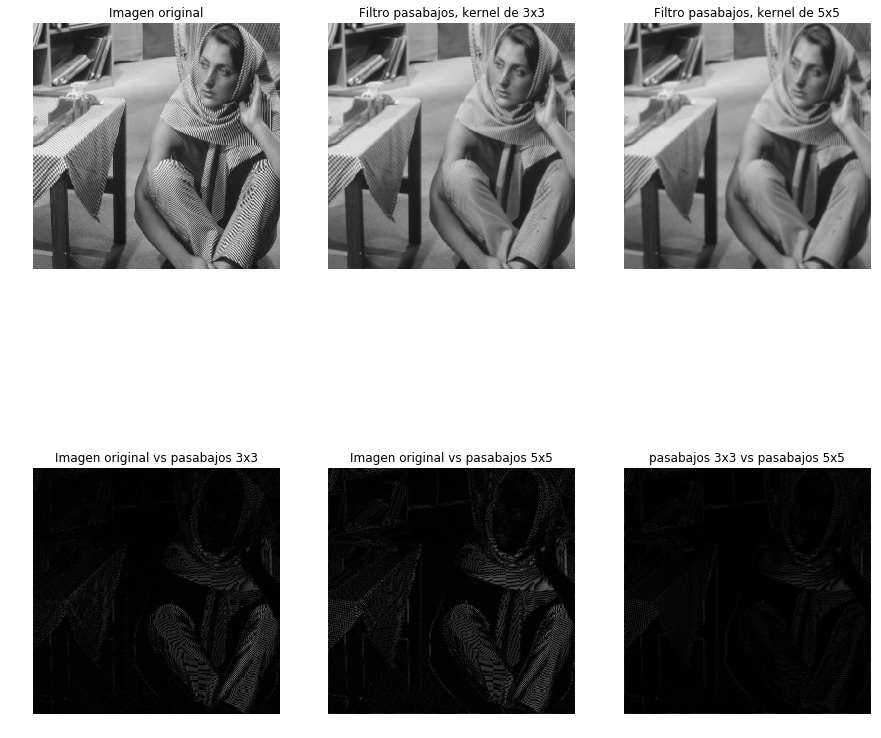

In [5]:
# Ploteo resultados
fig, axes = plt.subplots(ncols=3, nrows=2)

axes[0, 0].imshow(img)
axes[0, 0].set_title("Imagen original")

axes[0, 1].imshow(low_pass_img_3)
axes[0, 1].set_title("Filtro pasabajos, kernel de 3x3")

axes[0, 2].imshow(low_pass_img_5)
axes[0, 2].set_title("Filtro pasabajos, kernel de 5x5")

axes[1, 0].imshow(ImageChops.difference(img, low_pass_img_3))
axes[1, 0].set_title("Imagen original vs pasabajos 3x3")

axes[1, 1].imshow(ImageChops.difference(img, low_pass_img_5))
axes[1, 1].set_title("Imagen original vs pasabajos 5x5")

axes[1, 2].imshow(ImageChops.difference(low_pass_img_5, low_pass_img_3))
axes[1, 2].set_title("pasabajos 3x3 vs pasabajos 5x5")

for ax_list in axes:
    for ax in ax_list:
        ax.axis('off')

plt.show()

### b) Con una máscaras pasa-altos. 

In [6]:
def high_pass_mask(mask_shape):
    mask = np.zeros(mask_shape)
    mask[mask_shape[0]//2][mask_shape[1]//2] = 2
    mask -= low_pass_mask(mask_shape)
    return mask
    
def high_pass_filter(img, mask_shape):
    '''
    Dado el un valor n aplica un filtro pasabajos 
    sobre la imagen usando un kernel de dimension nxn
    '''
    mask = high_pass_mask(mask_shape)
    return convolve2d(img, mask, mode='same')

In [7]:
h_pass_3 = high_pass_filter(img, (3,3))
h_pass_5 = high_pass_filter(img, (5,5))

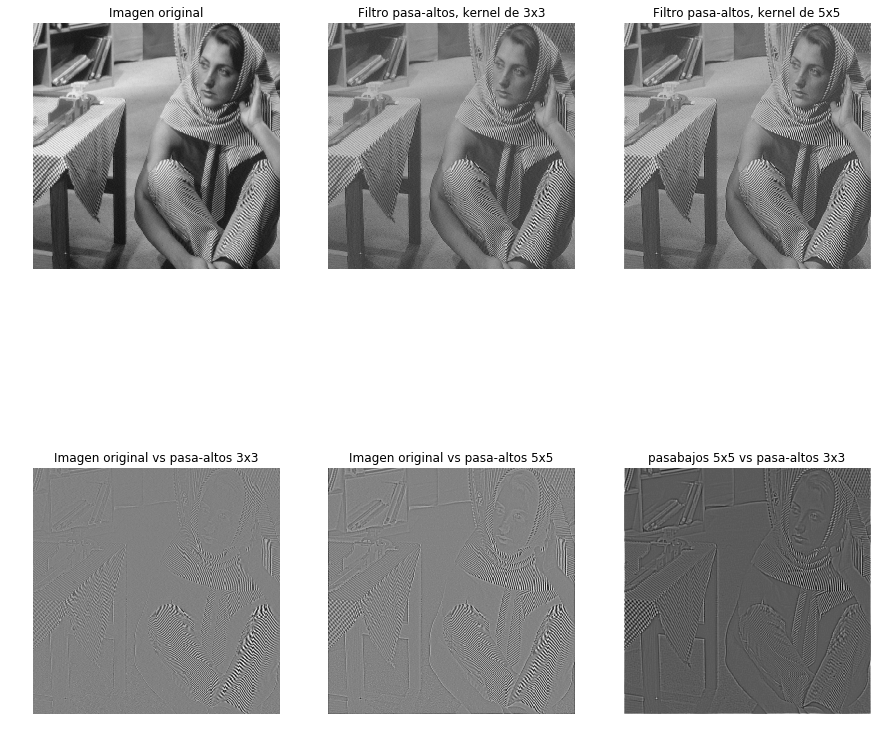

In [8]:
# Ploteo resultados
img_ar = np.asarray(img)
fig, axes = plt.subplots(ncols=3, nrows=2)

axes[0, 0].imshow(img)
axes[0, 0].set_title("Imagen original")

axes[0, 1].imshow(h_pass_3, cmap='gray')
axes[0, 1].set_title("Filtro pasa-altos, kernel de 3x3")

axes[0, 2].imshow(h_pass_5, cmap='gray')
axes[0, 2].set_title("Filtro pasa-altos, kernel de 5x5")

axes[1, 0].imshow(img_ar - h_pass_3, cmap='gray')
axes[1, 0].set_title("Imagen original vs pasa-altos 3x3")

axes[1, 1].imshow(img_ar - h_pass_5, cmap='gray')
axes[1, 1].set_title("Imagen original vs pasa-altos 5x5")

axes[1, 2].imshow(h_pass_5 - h_pass_3, cmap='gray')
axes[1, 2].set_title("pasabajos 5x5 vs pasa-altos 3x3")

for ax_list in axes:
    for ax in ax_list:
        ax.axis('off')

plt.show()

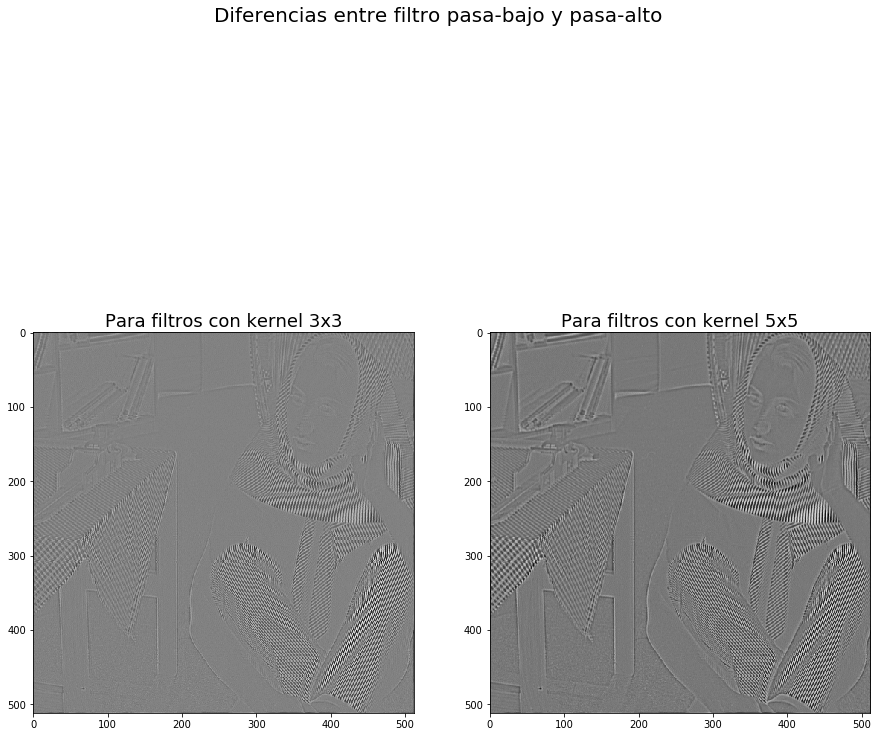

In [9]:
fig, axes = plt.subplots(ncols=2)
fig.suptitle("Diferencias entre filtro pasa-bajo y pasa-alto", size=20)

axes[0].imshow(low_pass_img_3 - h_pass_3, cmap='gray')
axes[0].set_title("Para filtros con kernel 3x3", size=18)
axes[1].imshow(low_pass_img_5 - h_pass_5, cmap='gray')
axes[1].set_title("Para filtros con kernel 5x5", size=18)

plt.show()

### 2) Implementar la aplicación de una máscara rectangular de dimensiones arbitrarias a una imagen.

Quedó hecho en la función convolve del punto 1.

### 3. Aplicar a test.png y lena.png máscaras para: 

In [10]:
test = Image.open('../img/Images_test/test.png')
lena = Image.open('../img/Images_test/lena.png')

### a) Suavizado

In [11]:
def gaussian_kernel(mask_shape, sigma):
    '''
    Genera un kernel gaussiano de las dimensiones pasadas por parámetro
    '''
    def gauss(x, y):
        return (1/(2*pi*(sigma**2)))*exp(-(x**2 + y **2)/(2 * (sigma ** 2)))
    
    mask = np.zeros(mask_shape)
    center_x = mask_shape[0]//2
    center_y = mask_shape[1]//2
    
    for x in range(mask_shape[0]):
        for y in range(mask_shape[1]):
            mask[x][y] = gauss(x-center_x, y-center_y)
    return mask

def gaussian_filter(img, mask_shape, sigma):
    mask = gaussian_kernel(mask_shape, sigma)
    return convolve2d(img, mask, mode='same')

def gf(img, mask_shape, sigma):
    '''
    Filtro gaussiano usando nuestra función de convolución
    (para comprobar que funciona correctamente, no la usamos
     porque es mucho más lenta que la de scipy)
    '''
    mask = gaussian_kernel(mask_shape, sigma)
    return convolve(img, mask)


In [12]:
soft_test = gaussian_filter(test, (5, 5), 1)
soft_lena = gaussian_filter(lena, (5, 5), 1)

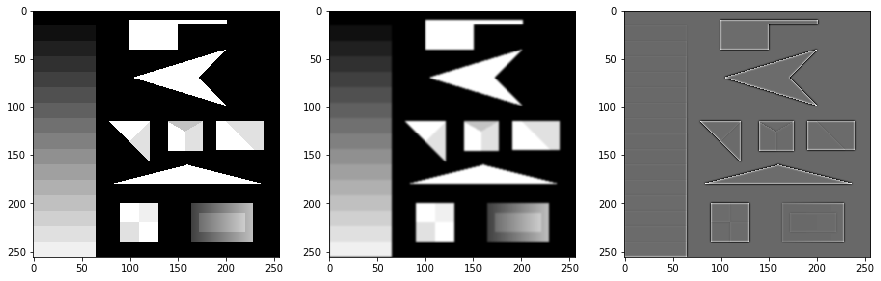

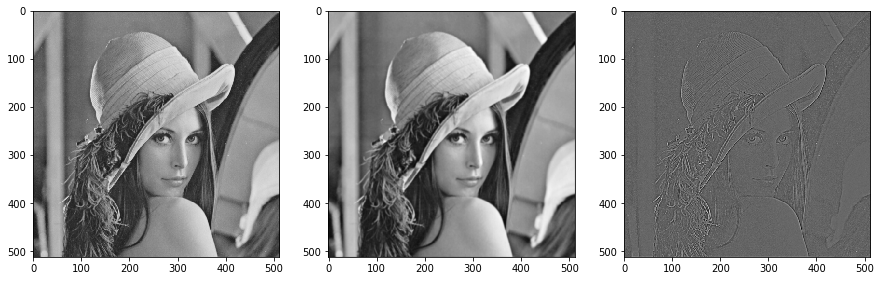

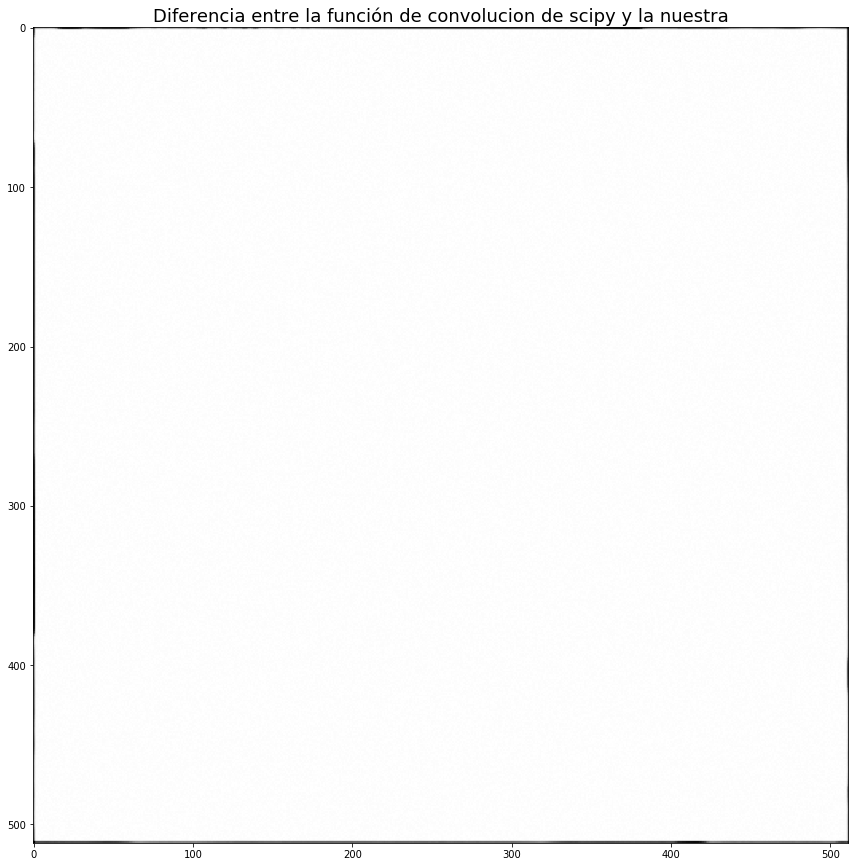

In [13]:
fig, axes = plt.subplots(ncols=3)

axes[0].imshow(test)
axes[1].imshow(soft_test, cmap='gray')
axes[2].imshow(np.asarray(test)-soft_test, cmap='gray')
plt.show()

fig, axes = plt.subplots(ncols=3)

axes[0].imshow(lena)
axes[1].imshow(soft_lena, cmap='gray')
axes[2].imshow(np.asarray(lena)-soft_lena, cmap='gray')

plt.show()

i = np.asarray(gf(lena, (5, 5), 1))

plt.imshow(soft_lena - i, cmap='gray')
plt.title("Diferencia entre la función de convolucion de scipy y la nuestra", size=18)
plt.show()

### b) Realce de bordes mediante *Unsharp Masking* 

In [14]:
def unsharpMasking(img, A):
    soft_img = gaussian_filter(img, (5, 5), 1)
    scaled_img = img.point(lambda i: A * i)
    return (scaled_img - soft_img)

In [15]:
sharper_test = high_pass_filter(test, (3, 3))
sharper_lena = high_pass_filter(lena, (3, 3))

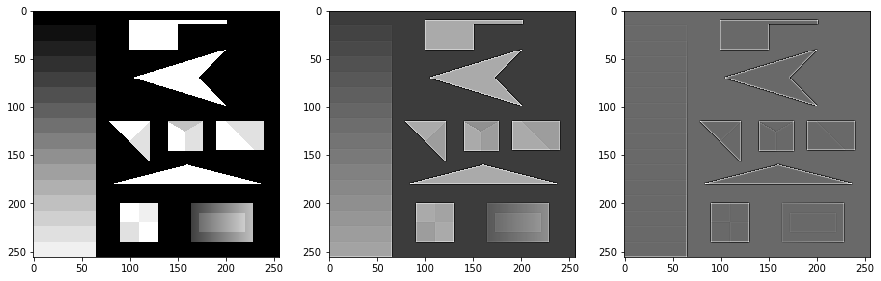

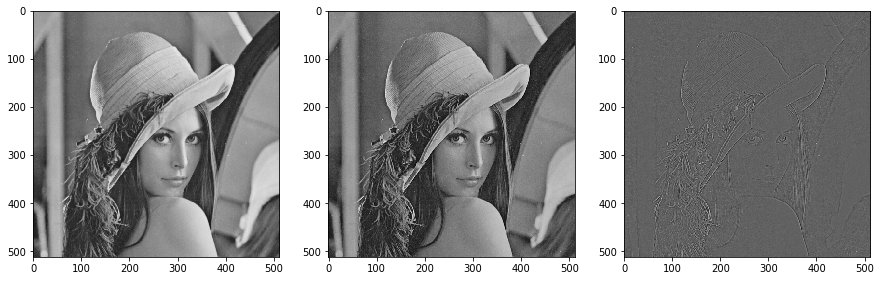

In [16]:
fig, axes = plt.subplots(ncols=3)

axes[0].imshow(test)
axes[1].imshow(sharper_test, cmap='gray')
axes[2].imshow(sharper_test - test, cmap='gray')
plt.show()

fig, axes = plt.subplots(ncols=3)

axes[0].imshow(lena)
axes[1].imshow(sharper_lena, cmap='gray')
axes[2].imshow(sharper_lena - lena, cmap='gray')

plt.show()


### 4. Repetir el ítem 3 luego de contaminar con: 

### a) Ruido Gaussiano Aditivo con distintos valores de  $\sigma$ y $\mu = 0$.

In [17]:
def addGaussianNoise(img, mu, sigma):
    return img.point(lambda x: x + random.gauss(mu, sigma))

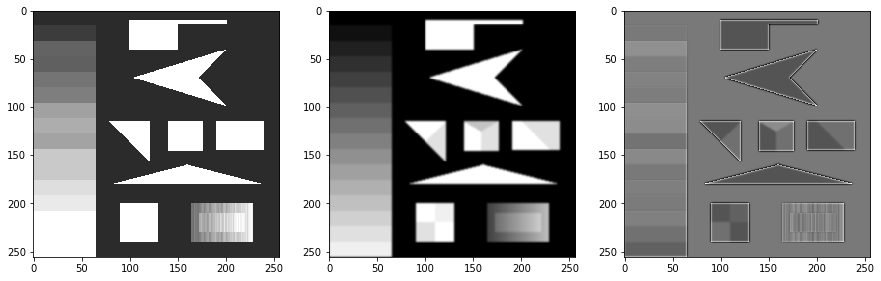

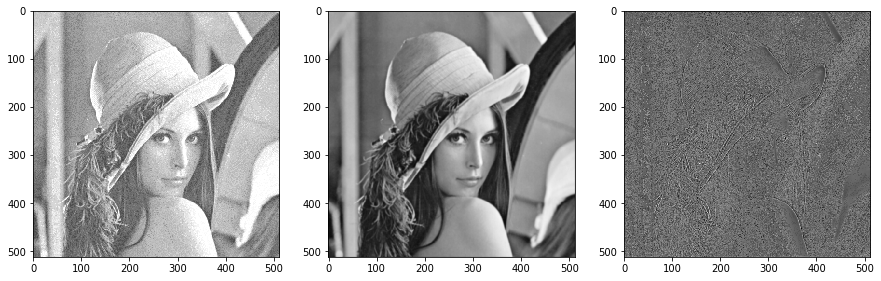

In [18]:
test_g = addGaussianNoise(test, 50, 10)
lena_g = addGaussianNoise(lena, 50, 10)

soft_test_g = gaussian_filter(test, (5, 5), 1)
soft_lena_g = gaussian_filter(lena, (5, 5), 1)

fig, axes = plt.subplots(ncols=3)

axes[0].imshow(test_g)
axes[1].imshow(soft_test_g, cmap='gray')
axes[2].imshow(test_g - soft_test_g, cmap='gray')
plt.show()

fig, axes = plt.subplots(ncols=3)

axes[0].imshow(lena_g)
axes[1].imshow(soft_lena_g, cmap='gray')
axes[2].imshow(lena_g - soft_lena_g, cmap='gray')

plt.show()

### b) Ruido Rayleigh Multiplicativo para distintos valores de $\xi$ 

In [19]:
def addRayleighNoise(img, xi):
    def pointRayleighNoise():
        u = np.random.uniform()
        return xi*sqrt(-2*log(u))
    
    return img.point(lambda x: x * pointRayleighNoise())

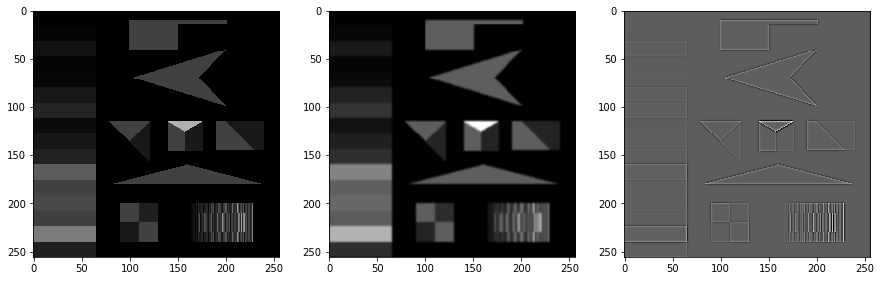

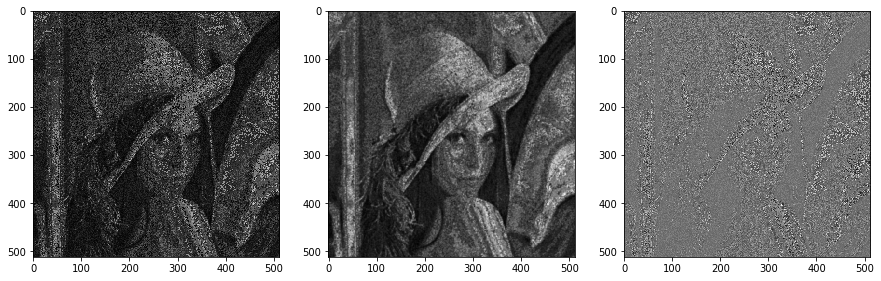

In [20]:
test_g = addRayleighNoise(test, .3)
lena_g = addRayleighNoise(lena, .3)

soft_test_g = gaussian_filter(test_g, (5, 5), 1)
soft_lena_g = gaussian_filter(lena_g, (5, 5), 1)

fig, axes = plt.subplots(ncols=3)

axes[0].imshow(test_g)
axes[1].imshow(soft_test_g, cmap='gray')
axes[2].imshow(test_g - soft_test_g, cmap='gray')
plt.show()

fig, axes = plt.subplots(ncols=3)

axes[0].imshow(lena_g)
axes[1].imshow(soft_lena_g, cmap='gray')
axes[2].imshow(lena_g - soft_lena_g, cmap='gray')

plt.show()

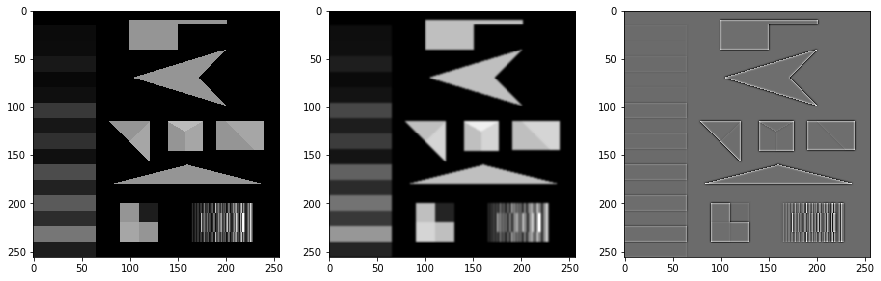

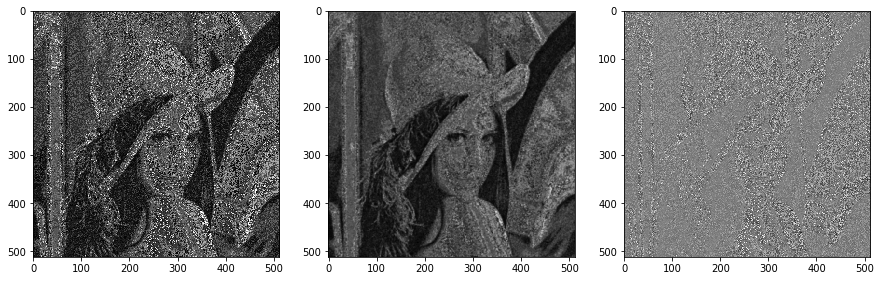

In [21]:
test_g = addRayleighNoise(test, .5)
lena_g = addRayleighNoise(lena, .5)

soft_test_g = gaussian_filter(test_g, (5, 5), 1)
soft_lena_g = gaussian_filter(lena_g, (5, 5), 1)

fig, axes = plt.subplots(ncols=3)

axes[0].imshow(test_g)
axes[1].imshow(soft_test_g, cmap='gray')
axes[2].imshow(test_g - soft_test_g, cmap='gray')
plt.show()

fig, axes = plt.subplots(ncols=3)

axes[0].imshow(lena_g)
axes[1].imshow(soft_lena_g, cmap='gray')
axes[2].imshow(lena_g - soft_lena_g, cmap='gray')

plt.show()

### 5. Implementar el filtro de mediana. 

In [22]:
def medianFilter(img, kernel_shape):
    img_ar = np.asarray(img, dtype='uint8')
    img_heigth, img_width = img_ar.shape
    mask_heigth, mask_width = kernel_shape
    
    # (center_x, center_y) marca el centro del kernel
    center_x = mask_heigth // 2
    center_y = mask_width // 2
    
    filtered_img = np.zeros(img_ar.shape, dtype='uint8')
    for x in range(img_heigth):
        for y in range(img_width):
            neighbourhood = []
            # Itero sobre las posiciones de la máscara
            for mask_x in range(mask_heigth):
                img_x_off = (x - center_x + mask_x) % img_heigth
                for mask_y in range(mask_width):
                    img_y_off = (y - center_y + mask_y) % img_width
                    neighbourhood.append(img_ar[img_x_off][img_y_off])
            filtered_img[x][y] = sorted(neighbourhood)[len(neighbourhood)//2]
            
    return Image.fromarray(filtered_img)

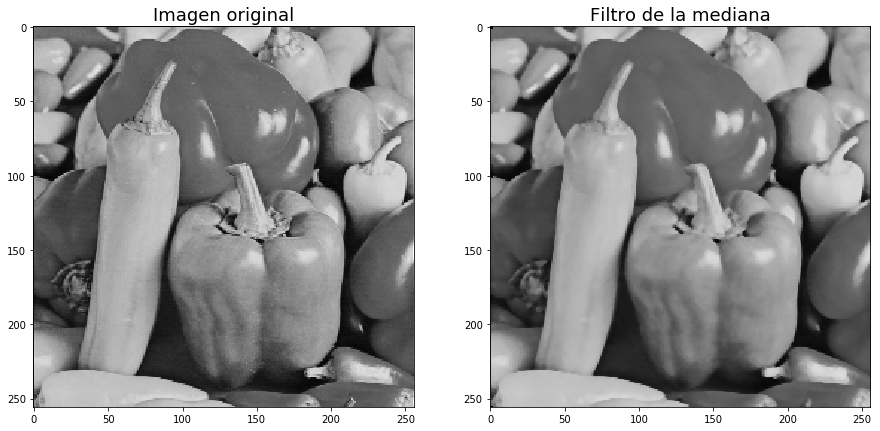

In [23]:
img = Image.open('../img/Images_test/peppers256.png')

fig, axes = plt.subplots(ncols=2)

axes[0].imshow(img)
axes[0].set_title("Imagen original", size=18)
axes[1].imshow(medianFilter(img, (3, 3)))
axes[1].set_title("Filtro de la mediana", size=18)

plt.show()

### 6. Contaminar las imágenes del ítem 3 con ruido impulsivo de distintas intensidades y aplicarles el filtro de la mediana. 

In [24]:
def spNoise(img, p_pepper, p_salt):
    def alter_pixel(x):
        choice = np.random.uniform()
        
        if choice < p_pepper:
            return 0
        elif choice > p_salt:
            return 255
        else:
            return x
        
    return img.point(alter_pixel)

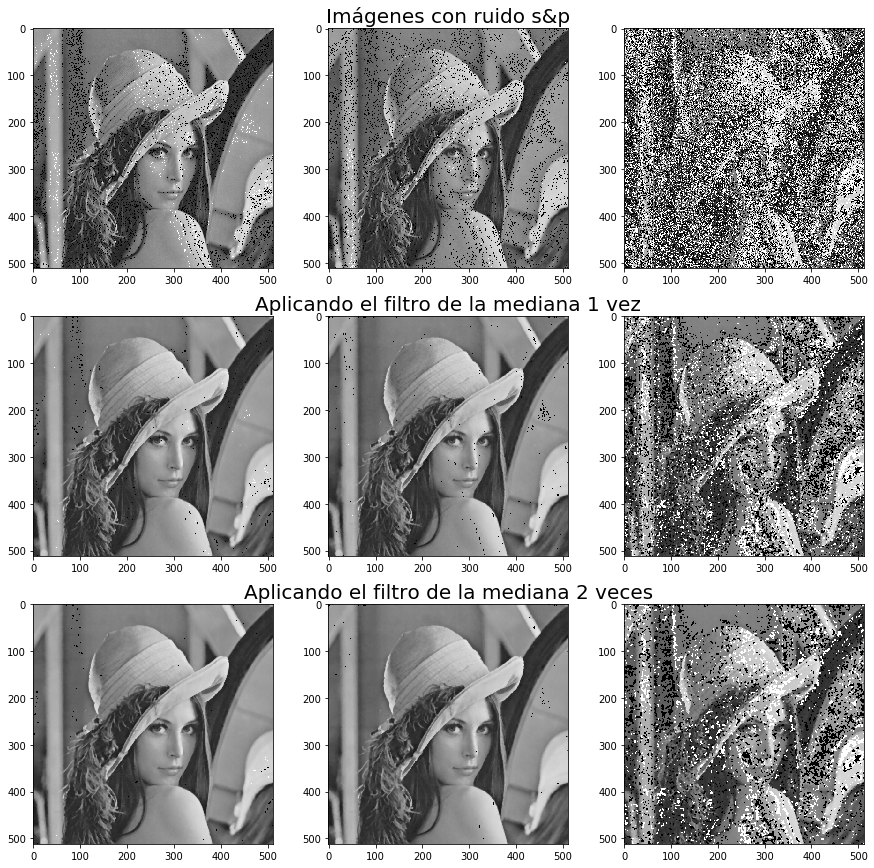

In [25]:
lena_l = spNoise(lena, 0.05, 0.995) 
lena_m = spNoise(lena, 0.1, 0.99)
lena_h = spNoise(lena, 0.3, 0.7)

median_lena_l = medianFilter(lena_l, (3, 3))
median_lena_m = medianFilter(lena_m, (3, 3))
median_lena_h = medianFilter(lena_h, (3, 3))

fig, axes = plt.subplots(ncols=3, nrows=3)

axes[0,0].imshow(lena_l)
axes[0,1].imshow(lena_m)
axes[0,2].imshow(lena_h)
axes[0,1].set_title("Imágenes con ruido s&p", size=20)


axes[1,0].imshow(median_lena_l)
axes[1,1].imshow(median_lena_m)
axes[1,2].imshow(median_lena_h)
axes[1,1].set_title("Aplicando el filtro de la mediana 1 vez", size=20)


axes[2,0].imshow(medianFilter(median_lena_l, (3, 3)))
axes[2,1].imshow(medianFilter(median_lena_m, (3, 3)))
axes[2,2].imshow(medianFilter(median_lena_h, (3, 3)))

axes[2,1].set_title("Aplicando el filtro de la mediana 2 veces", size=20)
plt.show()

### 7. Implementar el Detector de borde por método de gradiente para los siguientes operadores de gradiente:

In [26]:
def getGradient(img, kernel1, kernel2):
    Gx = np.asarray(convolve2d(img, kernel1, mode='same'))
    Gy = np.asarray(convolve2d(img, kernel2, mode='same'))
    
    gradient = np.sqrt(np.square(Gx) + np.square(Gy))
    return gradient

def getBorder(img, kernel1, kernel2):
    amt = 0
    g = getGradient(img, kernel1, kernel2)
    img_ar = np.asarray(img)
    border_img = np.zeros(img_ar.shape, dtype='uint8')
    low_bound = np.percentile(g, 90)
    for i in range(len(img_ar)):
        for j in range(len(img_ar[0])):
            if g[i][j] > low_bound:
                amt += 1
                border_img[i][j] = 255
                
    return Image.fromarray(border_img)
                

### a) Roberts. 

In [27]:
def Roberts(img):
    kernel1 = np.asarray([[-1, 0], [0, 1]])
    kernel2 = np.asarray([[0, -1], [1, 0]])
    return getBorder(img, kernel1, kernel2)    

In [28]:
img = Image.open('../img/Images_test/Bikesgray.jpg')
border = Roberts(img)

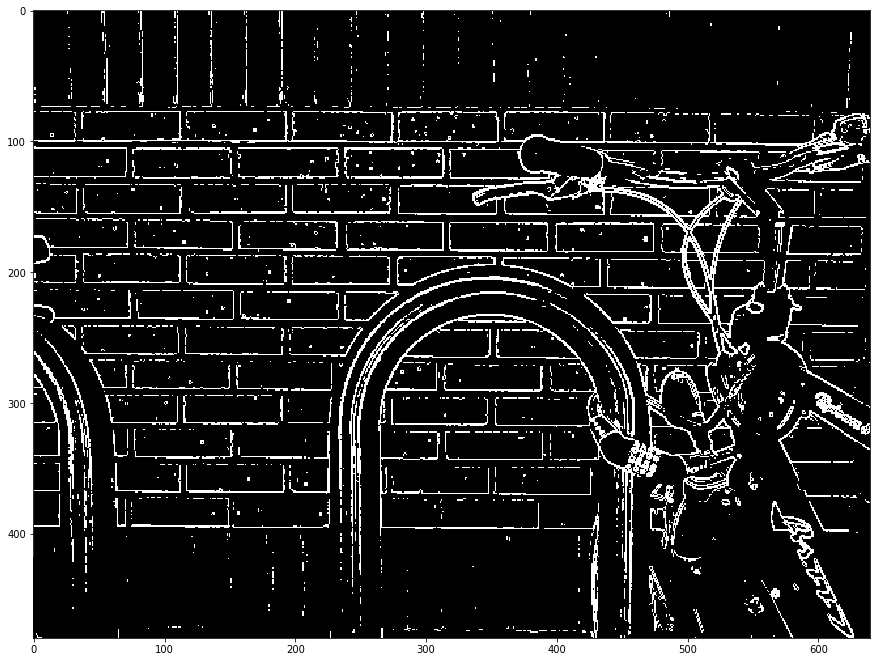

In [29]:
plt.imshow(border)
plt.show()


### b) Prewitt. 

In [30]:
def Prewitt(img):
    k1 = np.asarray([[-1,0,1],[-1,0,1],[-1,0,1]])
    k2 = np.asarray([[1,1,1],[0,0,0],[-1,-1,-1]])
    return getBorder(img, k1, k2)

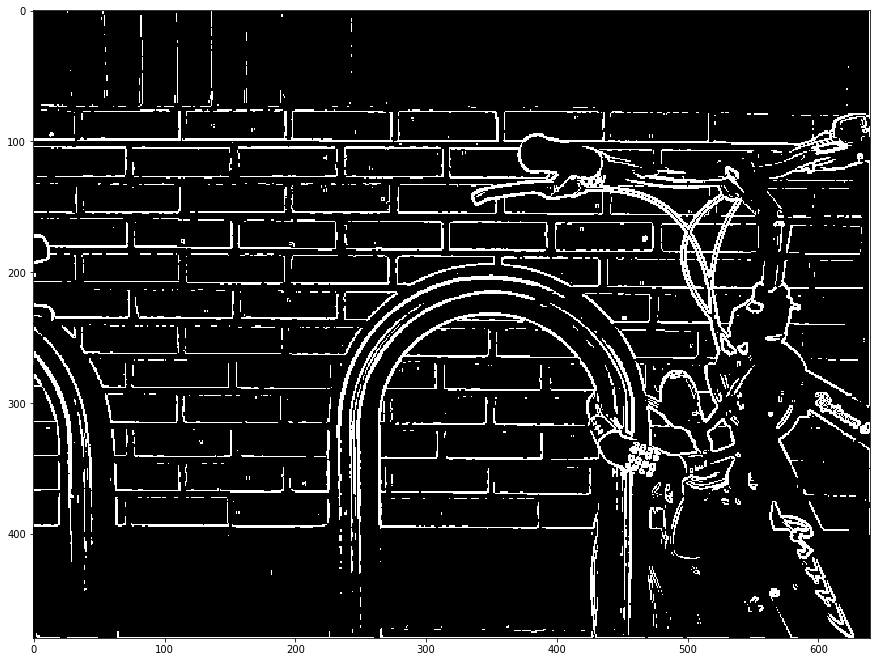

In [31]:
border_p = Prewitt(img)
plt.imshow(border_p)
plt.show()

### c) Sobel. 

In [32]:
def Sobel(img):
    k1 = np.asarray([[-1,0,1],[-2,0,2],[-1,0,1]])
    k2 = np.asarray([[1,2,1],[0,0,0],[-1,-2,-1]])
    return getBorder(img, k1, k2)

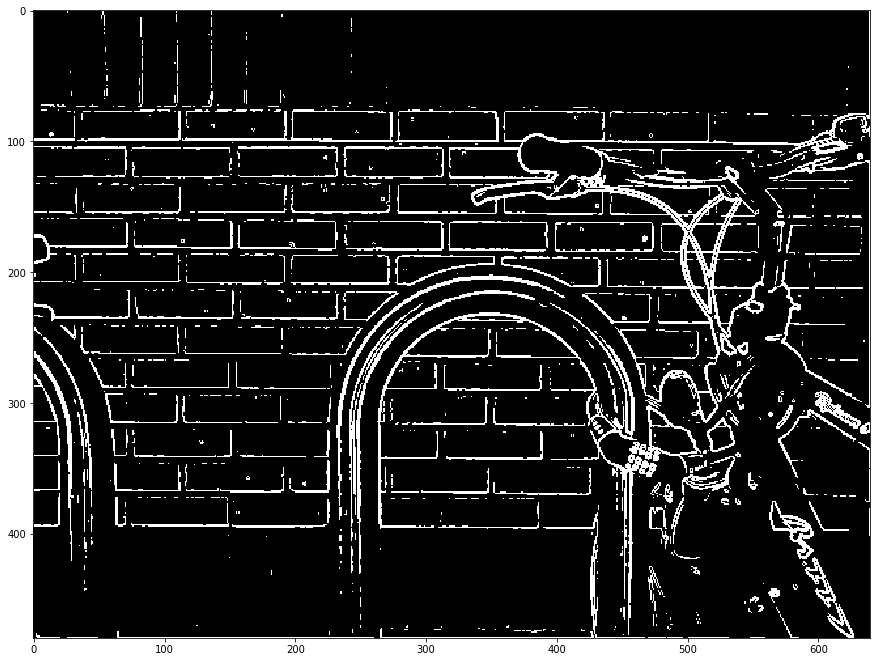

In [33]:
border_s = Sobel(img)
plt.imshow(border_s)
plt.show()

### 8. Aplicar los detectores de borde del ítem 7 a las imágenes del ítem 3 contaminadas con distintos ruidos.

#### Filtro de bordes para imagen con ruido Rayleigh

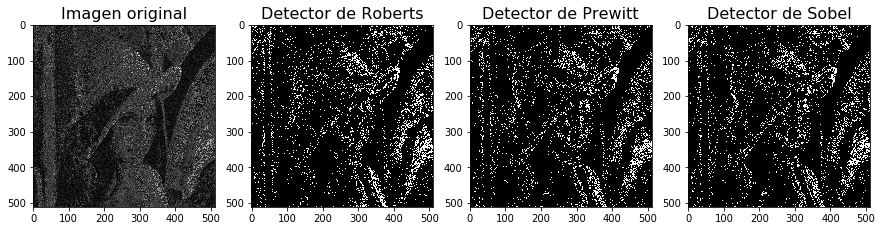

In [34]:
lena_r = addRayleighNoise(lena, 0.3)

fig, axes = plt.subplots(ncols=4)

axes[0].imshow(lena_r, cmap='gray')
axes[1].imshow(Roberts(lena_r), cmap='gray')
axes[2].imshow(Prewitt(lena_r), cmap='gray')
axes[3].imshow(Sobel(lena_r), cmap='gray')

axes[0].set_title('Imagen original', size=16)
axes[1].set_title('Detector de Roberts', size=16)
axes[2].set_title('Detector de Prewitt', size=16)
axes[3].set_title('Detector de Sobel', size=16)
plt.show()

#### Filtro de bordes para imagen con ruido Gaussiano

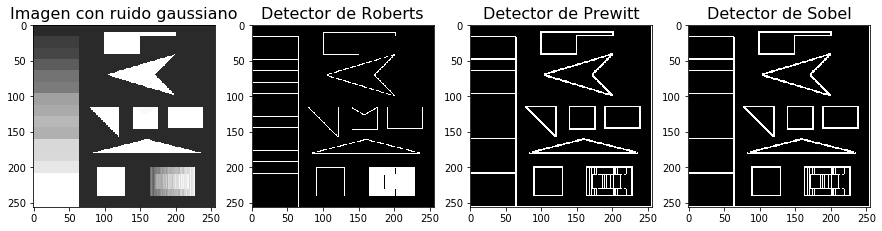

In [35]:
test_g = addGaussianNoise(test, 50, 10)

fig, axes = plt.subplots(ncols=4)

axes[0].imshow(test_g, cmap='gray')
axes[1].imshow(Roberts(test_g), cmap='gray')
axes[2].imshow(Prewitt(test_g), cmap='gray')
axes[3].imshow(Sobel(test_g), cmap='gray')

axes[0].set_title('Imagen con ruido gaussiano', size=16)
axes[1].set_title('Detector de Roberts', size=16)
axes[2].set_title('Detector de Prewitt', size=16)
axes[3].set_title('Detector de Sobel', size=16)
plt.show()

#### Filtro de borde para imagen con ruido impulsivo 

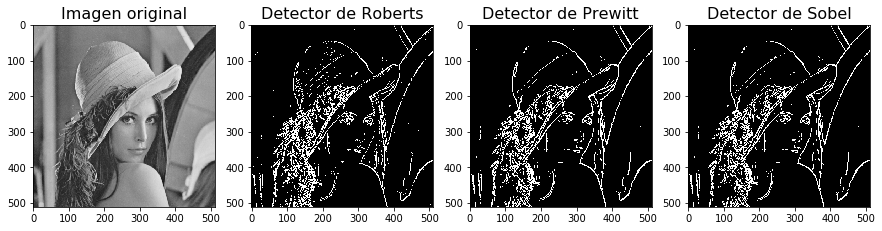

In [36]:
lena_sp = spNoise(lena, 0.005, 0.995)

fig, axes = plt.subplots(ncols=4)

axes[0].imshow(lena_sp, cmap='gray')
axes[1].imshow(Roberts(lena_sp), cmap='gray')
axes[2].imshow(Prewitt(lena_sp), cmap='gray')
axes[3].imshow(Sobel(lena_sp), cmap='gray')

axes[0].set_title('Imagen original', size=16)
axes[1].set_title('Detector de Roberts', size=16)
axes[2].set_title('Detector de Prewitt', size=16)
axes[3].set_title('Detector de Sobel', size=16)
plt.show()